In [ ]:
"""
NEXT
aに1要素のガウス、bに1要素のガウスを適応する
前提：aとbは同一空間上に存在している　Λ　aとbは相互作用をとる
  ここでは、a-lb , b-la とする

抑制が生じる事を確認する

"""

'\nzに1要素のガウスを適用\nzに1要素の2点のガウスの適応を試みるが、うまくいかない\n\nNEXT\naに1要素のガウス、bに1要素のガウスを適応する\n前提：aとbは同一空間上に存在している\u3000Λ\u3000aとbは独立である\n\nそれぞれが独立して拡散する事を確認する\n\nNEXT\naに1要素のガウス、bに1要素のガウスを適応する\n前提：aとbは同一空間上に存在している\u3000Λ\u3000aとbは相互作用をとる\n  ここでは、a-lb , b-la とする\n\n抑制が生じる事を確認する\n\n'

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt

In [22]:
def initial_field(x, y, pull_ini):

    x_max, y_max, dx, dy, wus_str, clv_str =\
      pull[0], pull[1], pull[2], pull[3], pull[4], pull[5]

    # 初期場(x方向をi, y方向をjとする行列を作成→2D画像のデータ構造を模擬)
    zero_wus = np.zeros((len(y), len(x)))
    zero_clv = np.zeros((len(y), len(x)))

    # 2D Gaussian(sigma:分散共分散行列, mu:平均ベクトル)
    sigma11, sigma22, sigma12, sigma21 = 0.3, 0.3, 0, 0
    sigma = np.array([[sigma11, sigma12],
                      [sigma21, sigma22]])
    det_sigma = np.linalg.det(sigma)
    inv_sigma = np.linalg.inv(sigma)


    def get_wus(z, mu_wus_x, mu_wus_y):
       mu_wus = np.array([mu_wus_x, mu_wus_y])

       def z_wus(z):
            z_wus = z.T
            for i in range(len(z)):
                for j in range(len(z.T)):
                    Xa = np.array([x[i], y[j]])
                    z_wus[i, j] = (1 / np.sqrt(2 * np.pi * det_sigma)) * np.exp((-1 / 2) * (Xa - mu_wus).T @ inv_sigma @ (Xa - mu_wus))
            return z_wus

       zz_wus = z_wus(z)
       zzz_wus = zz_wus.T

       return zzz_wus


    def get_clv(z, mu_clv_x, mu_clv_y):
       mu_clv = np.array([mu_clv_x, mu_clv_y])

       def z_clv(z):
            z_clv = z.T
            for i in range(len(z)):
                for j in range(len(z.T)):
                    Xb = np.array([x[i], y[j]])
                    z_clv[i, j] = (1 / np.sqrt(2 * np.pi * det_sigma)) * np.exp((-1 / 2) * (Xb - mu_clv).T @ inv_sigma @ (Xb - mu_clv))
            return z_clv

       zz_clv = z_clv(z)
       zzz_clv = zz_clv.T

       return zzz_clv

    mu_wus_x, mu_wus_y = 2.5, 1.0
    zzz_wus = get_wus(zero_wus, mu_wus_x, mu_wus_y)

    mu_clv_x, mu_clv_y = 2.5, 4.0
    zzz_clv = get_clv(zero_clv, mu_clv_x, mu_clv_y)

    #print(type(zz_wus))
    #print(zz_wus.shape)

    return zzz_wus, zzz_clv

def boundary_condition(a):
    a[:, 0], a[:, -1], a[0, :], a[-1, :] = 0, 0, 0, 0  # left,right,up.bottom

    return a


def sol_2d_diffusion(x, y, wus, clv, pull):
    ''' 2次元拡散方程式を計算する '''

    dt, dx, dy, a, step, result_interval =\
       pull[0], pull[1], pull[2], pull[3], pull[4], pull[5]

    wus = wus.T
    clv = clv.T

    for n in range(step):
        wus0 = wus.copy()
        clv0 = clv.copy()

        for i in range(1, len(wus) - 1):
            for j in range(1, len(wus.T) - 1):
                r = a * (dt / dx ** 2)
                s = a * (dt / dy ** 2)
                wus[i, j] = wus0[i, j] + r * (wus0[i+1, j] - 2 * wus0[i, j] + wus0[i-1, j]) + \
                          s * (wus0[i, j+1] - 2 * wus0[i, j] + wus0[i, j-1])
                clv[i, j] = clv0[i, j] + r * (clv0[i+1, j] - 2 * clv0[i, j] + clv0[i-1, j]) + \
                          s * (clv0[i, j+1] - 2 * clv0[i, j] + clv0[i, j-1])


        # 境界条件を設定
        wus = wus.T
        wus = boundary_condition(wus)
        wus = wus.T

        clv = clv.T
        clv = boundary_condition(clv)
        clv = clv.T


        # 指定した間隔で画像保存
        if n % result_interval == 0:
            print('Iteration=', n)

            wus = wus.T
            plot(x, y, wus, n, 1, wus_str)
            wus = wus.T

        if n % result_interval == 0:
            print('Iteration=', n)

            clv = clv.T
            plot(x, y, clv, n, 1, clv_str)
            clv = clv.T


    return

In [20]:
def plot(x, y, z, n, save_flag, name):

    plt.rcParams['font.size'] = 14
    # scale inside
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    x_size = 8
    y_size = int(0.8 * x_size * (np.max(y) / np.max(x)))
    fig = plt.figure(figsize=(x_size, y_size))
    ax1 = fig.add_subplot(111)
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.set_xlabel('x_label')
    ax1.set_ylabel('y_label')

    # データをプロットする。
    im = ax1.imshow(z,
                    vmin=0, vmax=1,
                    extent=[np.min(x), np.max(x), np.min(y), np.max(y)],
                    aspect='auto', cmap='jet')

    ax1.text(0.1, 0.1, 'Step='+str(n), color="white")

    # カラーバーを設定する。
    cbar = fig.colorbar(im)
    cbar.set_label(f'{name}')

    plt.show()

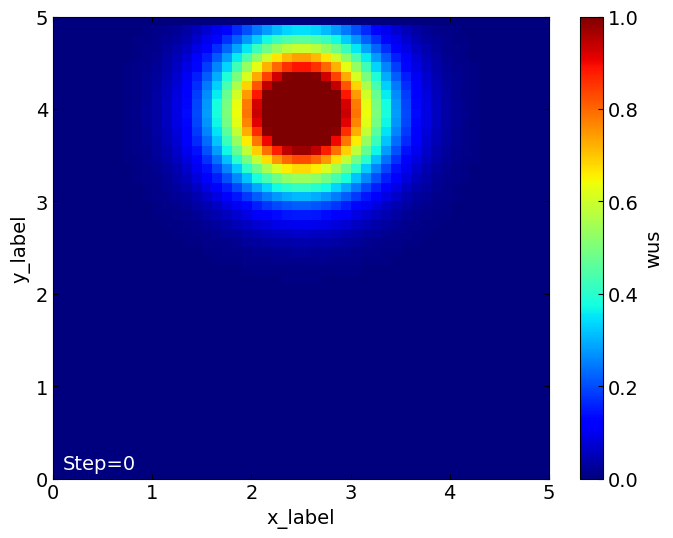

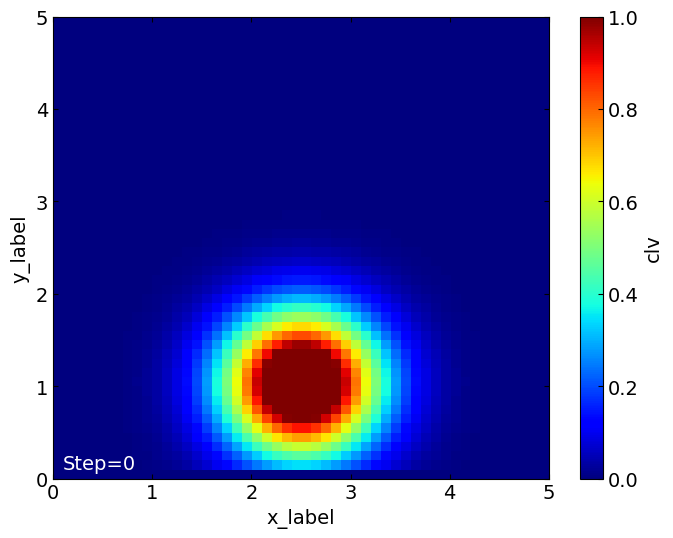

nu_x, nu_y= 0.04999999999999999 0.04999999999999999
Iteration= 0


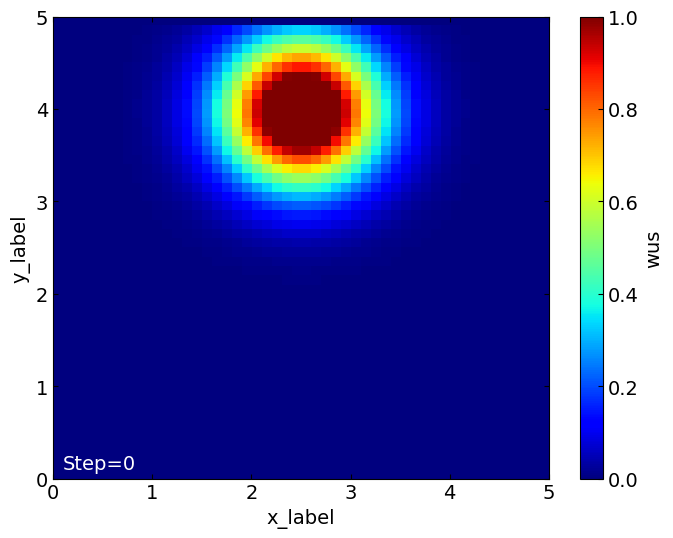

Iteration= 0


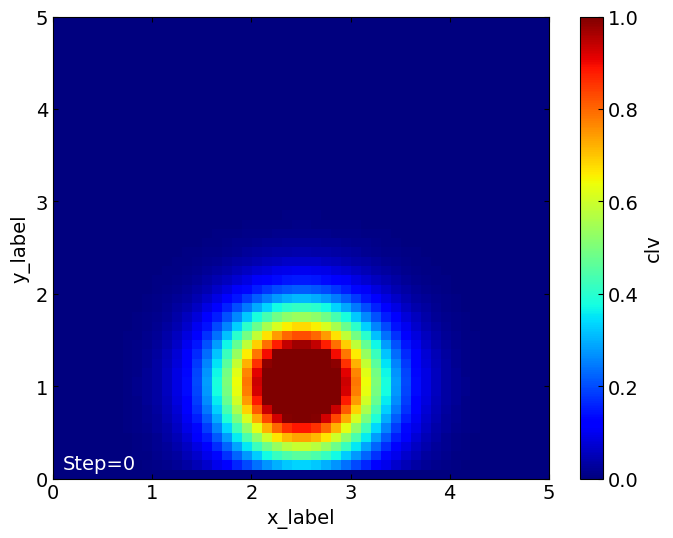

Iteration= 100


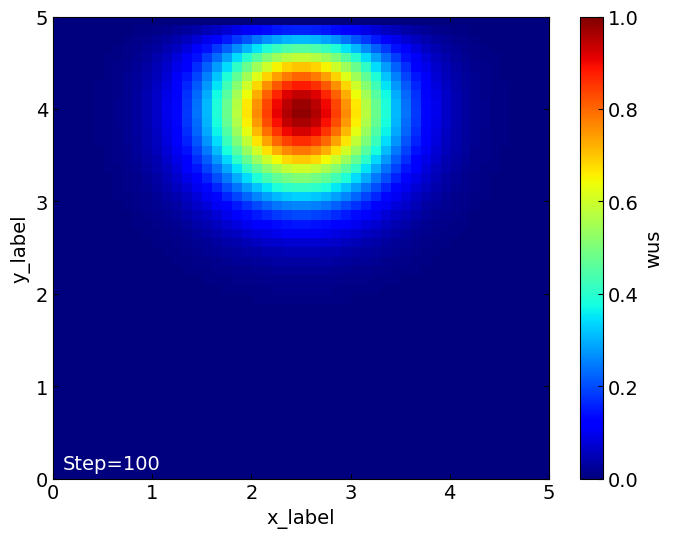

Iteration= 100


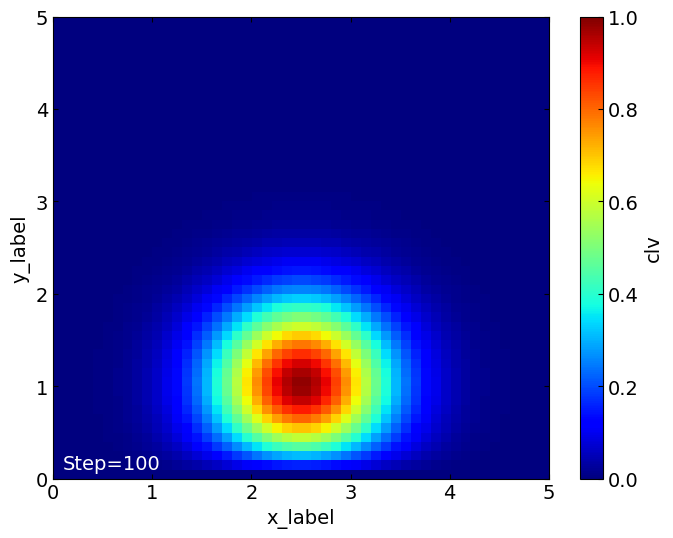

Iteration= 200


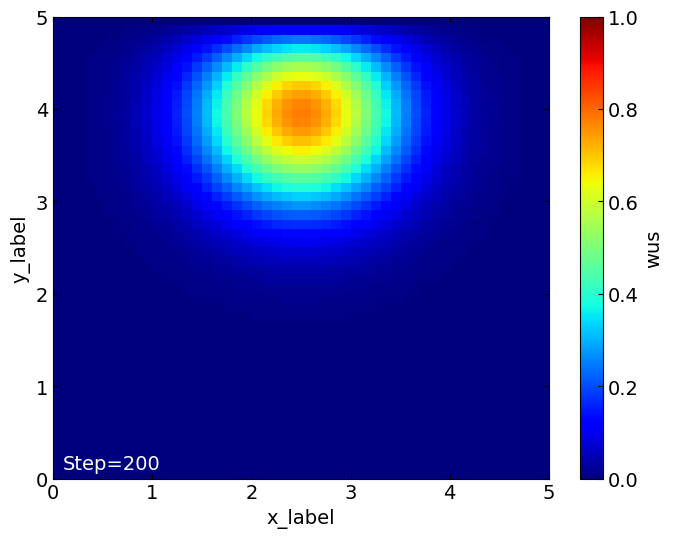

Iteration= 200


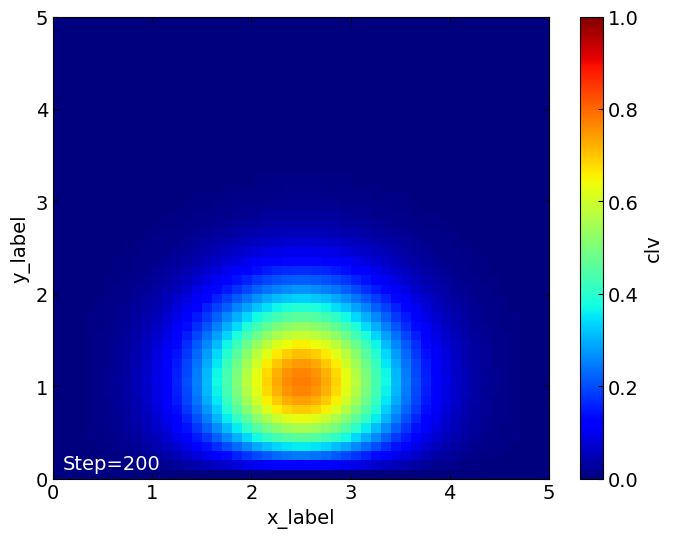

Iteration= 300


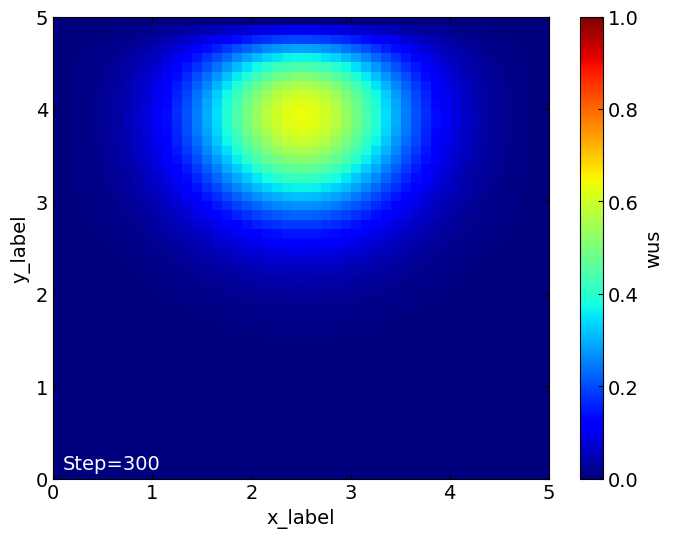

Iteration= 300


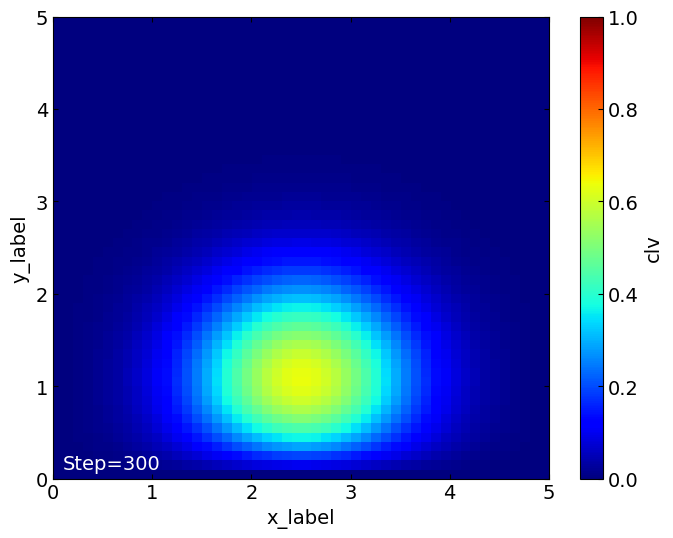

Iteration= 400


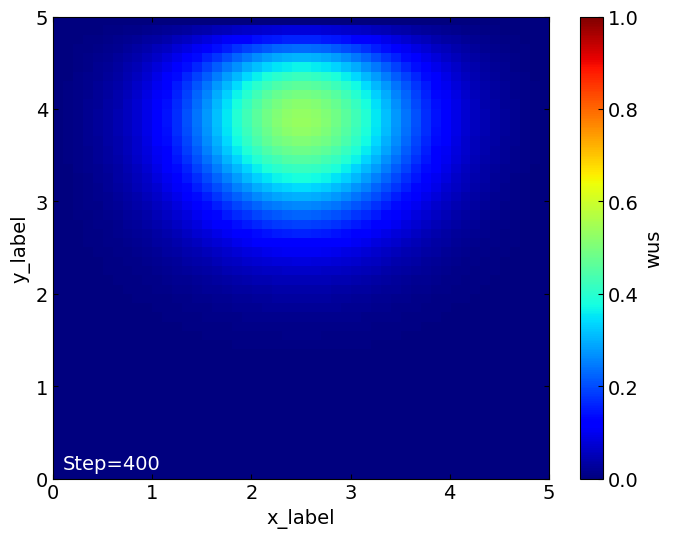

Iteration= 400


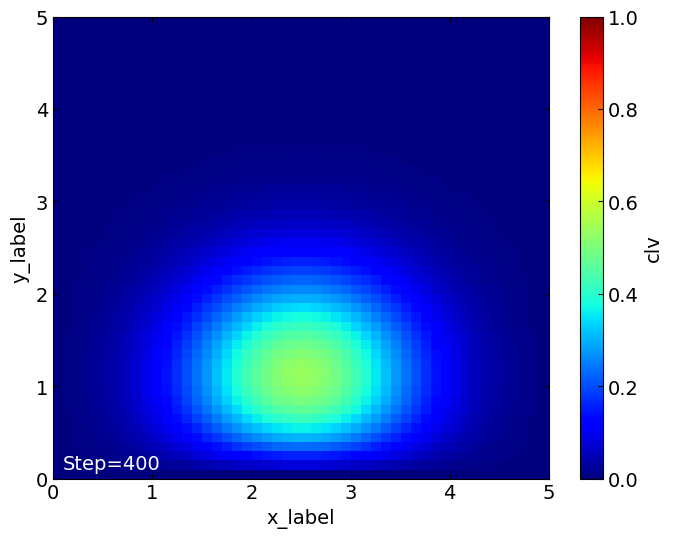

In [24]:
if __name__ == '__main__':

    wus_str, clv_str = 'wus', 'clv'

    # Parameter
    dt = 0.0005  # Time

    # Space
    x_max, y_max = 5, 5  # range
    dx, dy = 0.1, 0.1  # divide
    a = 1  # diffusion rate

    # Calculation condition
    step = 500
    result_interval = 100

    #引数list
    pull_ini = [x_max, y_max, dx, dy, wus_str, clv_str]
    pull_sol = [dt, dx, dy, a, step, result_interval]

    # Initial field
    x, y = np.linspace(0, x_max, int(x_max / dx)), np.linspace(0, y_max, int(y_max / dy))
    wus, clv = initial_field(x, y, pull_ini)
    #plot(x, y, wus, 0, dir, 0)

    # 境界条件を設定する
    wus = boundary_condition(wus)
    clv = boundary_condition(clv)
    plot(x, y, wus, 0, 0, wus_str)
    plot(x, y, clv, 0, 0, clv_str)

    # 安定性の確認
    nu_x, nu_y = a * dt / dx ** 2, a * dt / dy ** 2
    print('nu_x, nu_y=', nu_x, nu_y)

    # 計算を実行
    sol_2d_diffusion(x, y, wus, clv, pull_sol)


In [14]:
# wus = clv ???

x_max, y_max = 5, 5  # range
dx, dy = 0.1, 0.1  # divide

x, y = np.linspace(0, x_max, int(x_max / dx)), np.linspace(0, y_max, int(y_max / dy))
wus, clv = initial_field(x, y, x_max, y_max, dx, dy)

print(wus)
print(clv)

[[4.74395475e-02 6.55123314e-02 8.73840528e-02 ... 9.34082864e-12
  2.52417024e-12 6.58837773e-13]
 [6.55123314e-02 9.04702045e-02 1.20674276e-01 ... 1.28993528e-11
  3.48578951e-12 9.09831581e-13]
 [8.73840528e-02 1.20674276e-01 1.60962174e-01 ... 1.72058864e-11
  4.64954320e-12 1.21358482e-12]
 ...
 [9.34082864e-12 1.28993528e-11 1.72058864e-11 ... 1.83920556e-21
  4.97008148e-22 1.29724904e-22]
 [2.52417024e-12 3.48578951e-12 4.64954320e-12 ... 4.97008148e-22
  1.34306412e-22 3.50555346e-23]
 [6.58837773e-13 9.09831581e-13 1.21358482e-12 ... 1.29724904e-22
  3.50555346e-23 9.14990201e-24]]
[[9.14990201e-24 3.50555346e-23 1.29724904e-22 ... 1.21358482e-12
  9.09831581e-13 6.58837773e-13]
 [3.50555346e-23 1.34306412e-22 4.97008148e-22 ... 4.64954320e-12
  3.48578951e-12 2.52417024e-12]
 [1.29724904e-22 4.97008148e-22 1.83920556e-21 ... 1.72058864e-11
  1.28993528e-11 9.34082864e-12]
 ...
 [1.21358482e-12 4.64954320e-12 1.72058864e-11 ... 1.60962174e-01
  1.20674276e-01 8.73840528e-02]